In [8]:
import sys
print(sys.executable)




/Applications/Xcode.app/Contents/Developer/usr/bin/python3


In [9]:
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scikit-learn torch




Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl.metadata (60 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl (7.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 31.4 MB/s  0:00:00eta 0:00:01
Using cached contourpy-1.3.0-cp39-cp39-macosx_11_0_arm64.whl (249 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 34.4 MB/s  0:00:00
Using cached importlib_resources-6.5.

In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [11]:
# 1. Load and preprocess data
data = pd.read_csv("TSLA.csv")
data = data[['Close']]  # using only closing price

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [13]:
# 2. Create sequences
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_length = 60
x, y = create_sequences(scaled_data, seq_length)

In [14]:
# Convert to tensors
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1) 

# 3. Train/Test split 
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [16]:
# 4. GRU model
class StockPricePredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(StockPricePredictor, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # take output of last time step
        return out

input_size = 1
hidden_size = 128
num_layers = 3
model = StockPricePredictor(input_size, hidden_size, num_layers)

In [17]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
# 5. Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

Epoch [1/100], Loss: 0.036309
Epoch [2/100], Loss: 0.019826
Epoch [3/100], Loss: 0.026567
Epoch [4/100], Loss: 0.023026
Epoch [5/100], Loss: 0.018172
Epoch [6/100], Loss: 0.017270
Epoch [7/100], Loss: 0.018378
Epoch [8/100], Loss: 0.018481
Epoch [9/100], Loss: 0.016794
Epoch [10/100], Loss: 0.014337
Epoch [11/100], Loss: 0.012553
Epoch [12/100], Loss: 0.012148
Epoch [13/100], Loss: 0.011956
Epoch [14/100], Loss: 0.010154
Epoch [15/100], Loss: 0.007213
Epoch [16/100], Loss: 0.005141
Epoch [17/100], Loss: 0.004512
Epoch [18/100], Loss: 0.003180
Epoch [19/100], Loss: 0.000673
Epoch [20/100], Loss: 0.001047
Epoch [21/100], Loss: 0.002718
Epoch [22/100], Loss: 0.002038
Epoch [23/100], Loss: 0.003538
Epoch [24/100], Loss: 0.002541
Epoch [25/100], Loss: 0.000908
Epoch [26/100], Loss: 0.000941
Epoch [27/100], Loss: 0.000741
Epoch [28/100], Loss: 0.000313
Epoch [29/100], Loss: 0.000566
Epoch [30/100], Loss: 0.001089
Epoch [31/100], Loss: 0.001239
Epoch [32/100], Loss: 0.001068
Epoch [33/100], L

In [19]:
# 6. Evaluation
model.eval()
with torch.no_grad():
    predictions = model(x_test)
    predictions = scaler.inverse_transform(predictions.numpy())
    actual = scaler.inverse_transform(y_test.numpy())

In [20]:
# Function to predict future stock prices based on user input
def predict_future(data, model, scaler, seq_length, num_predictions):
    last_sequence = data[-seq_length:]
    predictions = []

    model.eval()
    with torch.no_grad():
        for _ in range(num_predictions):
            input_seq = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0)
            next_value = model(input_seq)
            predictions.append(next_value.item())
            next_value_scaled = next_value.numpy()
            last_sequence = np.append(last_sequence[1:], next_value_scaled, axis=0)
    
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions

num_predictions = int(input("Enter the number of future days to predict: "))
future_predictions = predict_future(scaled_data, model, scaler, seq_length, num_predictions)

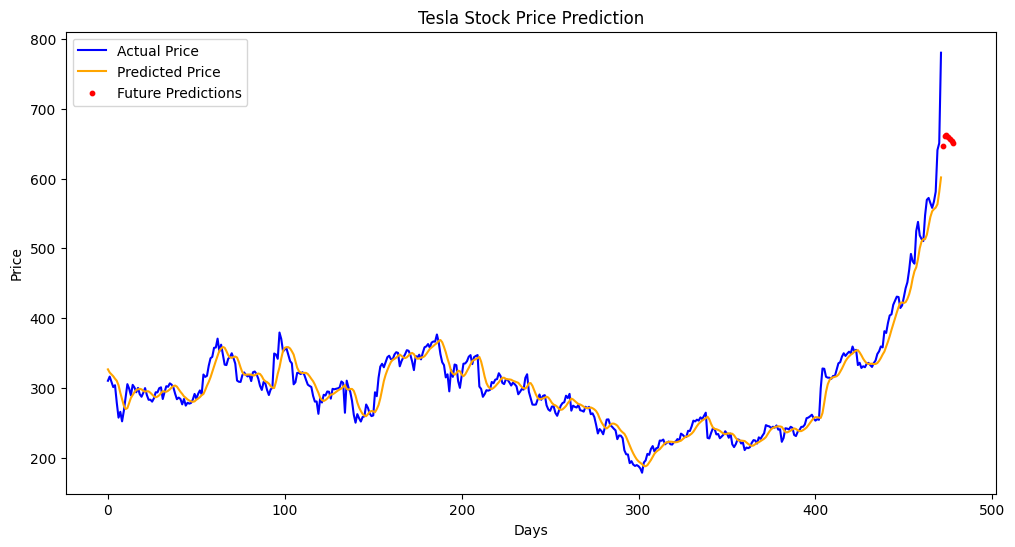

In [21]:
# Extend the x-axis for future predictions
future_days = np.arange(len(actual), len(actual) + num_predictions)

# Plot the actual, predicted, and future predictions
plt.figure(figsize=(12, 6))
plt.plot(actual, label="Actual Price", color="blue")
plt.plot(predictions, label="Predicted Price", color="orange")
plt.scatter(future_days, future_predictions, label="Future Predictions", color="red", s=10)
plt.title("Tesla Stock Price Prediction")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

In [22]:
import torch
print("MPS available:", torch.backends.mps.is_available())

MPS available: True


In [23]:
!pip install tensorflow


Defaulting to user installation because normal site-packages is not writeable
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached charset_normalizer-3.4.3-cp39-cp39-macosx_10_9_universal2.whl.metadata (36 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.8.3-py3-none-any.whl.metadata (2.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.4/200.4 MB 33.3 MB/s  0:00:06m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 32.6 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.6/663.6 kB 20.0 MB/s  0:00:00
Using cached requests-2.32.5-py3-none-any.whl (64 kB)
Using cached charset_normalizer-3.4.3-cp39-cp39-macosx_10_9_universal2.whl (207 kB)
Using cached idna-3.10-py3-none-any.whl (70 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 29.1 MB/s  0:00:00
Using cached urllib3-2.5.0-py3-none-any.whl (129 kB)
Usi

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
 
device = torch.device("mps")  # Apple GPU
 
# Dummy data
X = torch.randn(100, 10).to(device)
y = torch.randn(100, 1).to(device)
 
# Simple model
model = nn.Linear(10, 1).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
 
# Training
for epoch in range(555):
    optimizer.zero_grad()
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 1.5701
Epoch 2, Loss: 1.5293
Epoch 3, Loss: 1.4903
Epoch 4, Loss: 1.4533
Epoch 5, Loss: 1.4181
Epoch 6, Loss: 1.3848
Epoch 7, Loss: 1.3534
Epoch 8, Loss: 1.3237
Epoch 9, Loss: 1.2958
Epoch 10, Loss: 1.2695
Epoch 11, Loss: 1.2448
Epoch 12, Loss: 1.2217
Epoch 13, Loss: 1.2000
Epoch 14, Loss: 1.1796
Epoch 15, Loss: 1.1606
Epoch 16, Loss: 1.1428
Epoch 17, Loss: 1.1262
Epoch 18, Loss: 1.1107
Epoch 19, Loss: 1.0962
Epoch 20, Loss: 1.0828
Epoch 21, Loss: 1.0703
Epoch 22, Loss: 1.0587
Epoch 23, Loss: 1.0481
Epoch 24, Loss: 1.0382
Epoch 25, Loss: 1.0292
Epoch 26, Loss: 1.0210
Epoch 27, Loss: 1.0135
Epoch 28, Loss: 1.0068
Epoch 29, Loss: 1.0008
Epoch 30, Loss: 0.9954
Epoch 31, Loss: 0.9905
Epoch 32, Loss: 0.9863
Epoch 33, Loss: 0.9825
Epoch 34, Loss: 0.9792
Epoch 35, Loss: 0.9763
Epoch 36, Loss: 0.9737
Epoch 37, Loss: 0.9715
Epoch 38, Loss: 0.9695
Epoch 39, Loss: 0.9678
Epoch 40, Loss: 0.9663
Epoch 41, Loss: 0.9650
Epoch 42, Loss: 0.9639
Epoch 43, Loss: 0.9629
Epoch 44, Loss: 0.96